In [6]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Directorio de entrenamiento
train_dir = 'C:/Users/salas/Documents/Tarea1Estadistica/uco-animals-vs-plants/train'

#Dimensiones de las imágenes ajustadas a 224x224
img_height, img_width = 224, 224
batch_size = 32

#Generador de datos con Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=15,        # Aumento de rotación
    width_shift_range=0.15,   # Aumento de desplazamiento horizontal
    height_shift_range=0.15,  # Aumento de desplazamiento vertical
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=[0.9, 1.1]  # Rango de brillo ajustado
)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

#Numero de clases (detectado automáticamente por el generador)
num_classes = len(train_generator.class_indices)

#Cargar el modelo MobileNetV2 preentrenado
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congela las capas del modelo base

#Crear el modelo completo con capas adicionales
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),              # Dropout inicial conservado en 0.5
    Dense(512, activation='relu'),
    Dropout(0.3),              # Dropout reducido a 0.3 en la última capa
    Dense(num_classes, activation='softmax')
])

#Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#Configuración de callbacks para reducir sobreajuste
early_stop = EarlyStopping(
    monitor='val_loss',        #Monitorear la pérdida de validación
    patience=5,                #paciencia para detener el entrenamiento temprano
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        #Monitorear la pérdida de validación
    factor=0.5,                #Reducir la tasa de aprendizaje a la mitad si no mejora
    patience=3,                #paciencia antes de reducir la tasa de aprendizaje
    min_lr=1e-6,               #tasa de aprendizaje mínima
    verbose=1
)

#Descongelar las últimas capas del modelo base para ajuste fino
for layer in base_model.layers[-30:]:
    layer.trainable = True

#epocas
epochs = 30  # Ajusta segun sea necesario

# Entrenar el modelo con los callbacks configurados
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)




Found 4331 images belonging to 16 classes.
Found 1075 images belonging to 16 classes.
Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 81s 562ms/step - accuracy: 0.2728 - loss: 2.3048 - val_accuracy: 0.3730 - val_loss: 2.1026 - learning_rate: 1.0000e-04
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 74s 543ms/step - accuracy: 0.6978 - loss: 0.9022 - val_accuracy: 0.5172 - val_loss: 1.8507 - learning_rate: 1.0000e-04
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 76s 559ms/step - accuracy: 0.7925 - loss: 0.6008 - val_accuracy: 0.7544 - val_loss: 0.7950 - learning_rate: 1.0000e-04
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 78s 572ms/step - accuracy: 0.8406 - loss: 0.4511 - val_accuracy: 0.7693 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 592ms/step - accuracy: 0.8650 - loss: 0.3826 - val_accuracy: 0.7972 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 76s 560ms/step - accuracy: 0.8881 - loss: 0.3237 - val_accuracy: 0.7805 - val_l

In [18]:
# Etiquetas de validación reales
validation_labels = validation_generator.classes

# Realizar predicciones en el conjunto de validacion con el modelo CNN
cnn_validation_predictions = model.predict(validation_generator, verbose=1)
cnn_validation_predictions = np.argmax(cnn_validation_predictions, axis=1)


# Ruta de las imagenes de prueba
testPath = "C:/Users/salas/Documents/Tarea1Estadistica/uco-animals-vs-plants/test/unlabeled"

#Tamaño de las imagenes de prueba actualizado a 224x224
IMG_SIZE_LR = 200

#Función para cargar y redimensionar imágenes de prueba
def load_and_resize_test_images(path, imgSize=IMG_SIZE_LR, grayscale=False):
    images = []
    filenames = []
    for file in os.listdir(path):
        imgPath = os.path.join(path, file)
        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
        
        #Verificar si la imagen se cargo correctamente
        if img is None:
            print(f"Advertencia: No se pudo cargar la imagen {file}. Se omitirá.")
            continue
        
        # Redimensionar la imagen al tamaño esperado por el modelo
        img = cv2.resize(img, (imgSize, imgSize))
        img = img / 255.0  # Normalizar

        #Asegurarse de que la imagen tiene 3 canales (RGB)
        if grayscale:
            img = np.expand_dims(img, axis=-1)
        elif img.shape[-1] == 1:  #Si esta en escala de grises, convertir a 3 canales
            img = np.stack([img] * 3, axis=-1)

        images.append(img)
        filenames.append(os.path.basename(file))
    
    return np.array(images), filenames

#Cargar y redimensionar imagenes de prueba
test_images, test_filenames = load_and_resize_test_images(testPath, imgSize=IMG_SIZE_LR, grayscale=False)

#Verificar el tamaño de las imagenes cargadas
print("Tamaño de test_images:", test_images.shape)  # Esto debería mostrar (número de imágenes, 224, 224, 3)

#Realizar predicciones con el modelo
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)  # Obtener la clase con mayor probabilidad

#Mapeo de indices a nombres de clase
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

#Convertir indices a nombres de clase en las predicciones
class_predictions = [index_to_class[pred] for pred in predictions]

#Crear el archivo de envio
submission = pd.DataFrame({
    'file': test_filenames,
    'label': class_predictions
})

submission.to_csv('submission2.csv', index=False)
print("Archivo de predicciones guardado como 'submission2.csv'")


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step
Tamaño de test_images: (962, 200, 200, 3)
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
Archivo de predicciones guardado como 'submission2.csv'


In [19]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import dump

#Directorio de entrenamiento
train_dir = 'C:/Users/salas/Documents/Tarea1Estadistica/uco-animals-vs-plants/train'

#Dimensiones de las imágenes ajustadas a 224x224
img_height, img_width = 224, 224
batch_size = 32

#Generador de datos sin aumentacion (solo para extraccion de caracteristicas)
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False  # No mezclar para mantener el orden de las caracteristicas
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

#Cargar MobileNetV2 como extractor de caracteristicas
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

#Extraer caracteristicas de las imagenes de entrenamiento
train_features = feature_extractor.predict(train_generator, verbose=1)
train_labels = train_generator.classes  # Etiquetas reales de entrenamiento

#Extraer características de las imagenes de validación
validation_features = feature_extractor.predict(validation_generator, verbose=1)
validation_labels = validation_generator.classes  # Etiquetas reales de validación

#Entrenar modelo de regresión logistica
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
logistic_model.fit(train_features, train_labels)

#Evaluar el modelo en el conjunto de validacion
validation_predictions = logistic_model.predict(validation_features)
validation_accuracy = accuracy_score(validation_labels, validation_predictions)
print("Exactitud en el conjunto de validación:", validation_accuracy)

#Guardar el modelo de regresion logistica entrenado
dump(logistic_model, 'logistic_regression_model.joblib')

#Realizar predicciones en el conjunto de prueba
testPath = "C:/Users/salas/Documents/Tarea1Estadistica/uco-animals-vs-plants/test/unlabeled"

#Funcion para cargar y redimensionar imagenes de prueba
def load_and_resize_test_images(path, imgSize=img_height, grayscale=False):
    images = []
    filenames = []
    for file in os.listdir(path):
        imgPath = os.path.join(path, file)
        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
        
        if img is None:
            print(f"Advertencia: No se pudo cargar la imagen {file}. Se omitirá.")
            continue
        
        img = cv2.resize(img, (imgSize, imgSize))
        img = img / 255.0  # Normalizar

        if grayscale:
            img = np.expand_dims(img, axis=-1)
        elif img.shape[-1] == 1:
            img = np.stack([img] * 3, axis=-1)

        images.append(img)
        filenames.append(os.path.basename(file))
    
    return np.array(images), filenames

#cargar la imgenes de prueba y extraer caracteristicas
test_images, test_filenames = load_and_resize_test_images(testPath, imgSize=img_height)
test_features = feature_extractor.predict(test_images, verbose=1)

#Predicciones con el modelo de regresion logistica
test_predictions = logistic_model.predict(test_features)

#Mapeo de indices a nombres de clase
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

#Convertir indices a nombres de clase en las predicciones
class_predictions = [index_to_class[pred] for pred in test_predictions]

#Crear el archivo de envio para Kaggle
submission = pd.DataFrame({
    'file': test_filenames,
    'label': class_predictions
})

submission.to_csv('submission_logistic.csv', index=False)
print("Archivo de predicciones guardado como 'submission_logistic.csv'")


Found 4331 images belonging to 16 classes.
Found 1075 images belonging to 16 classes.


C:\Users\salas\miniforge3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step


C:\Users\salas\miniforge3\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Exactitud en el conjunto de validación: 0.8493023255813954
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step
Archivo de predicciones guardado como 'submission_logistic.csv'


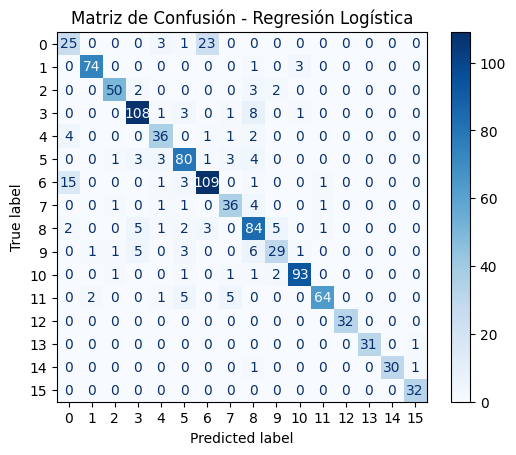

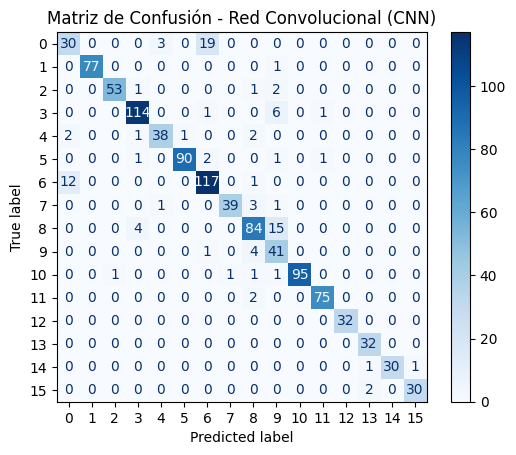

Exactitud de Regresión Logística: 0.8493023255813954
Exactitud de Red Convolucional: 0.9088372093023256


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

#Matriz de confusion para el modelo de regresion logistica
conf_matrix_logistic = confusion_matrix(validation_labels, validation_predictions)
ConfusionMatrixDisplay(conf_matrix_logistic).plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

#Matriz de confusion para el modelo CNN
conf_matrix_cnn = confusion_matrix(validation_labels, cnn_validation_predictions)
ConfusionMatrixDisplay(conf_matrix_cnn).plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Red Convolucional (CNN)')
plt.show()

#Calcular y mostrar las precisiones de ambos modelos
logistic_accuracy = accuracy_score(validation_labels, validation_predictions)
cnn_accuracy = accuracy_score(validation_labels, cnn_validation_predictions)
print(f"Exactitud de Regresión Logística: {logistic_accuracy}")
print(f"Exactitud de Red Convolucional: {cnn_accuracy}")
